In [1]:
from base64 import encode
from hashlib import new
from multiprocessing import shared_memory
from os import abort
import numpy as np
import SimpleITK as sitk
import cv2 as cv2
from collections import defaultdict
import matplotlib.pyplot as plt

BPLINE_BOARD_SIZE=3

def init_param(row_block_num, col_block_num, min_x, max_x):
    '''
    初始化FFD参数的代码
    :input 行块列块个数，随机数的最小和最大值
    :output 将行列块的特征点展平成一维向量
    '''
    grid_rows = row_block_num + BPLINE_BOARD_SIZE
    grid_cols = col_block_num + BPLINE_BOARD_SIZE#网格的行和列
    grid_size = grid_rows*grid_cols
    grid_points = (max_x-min_x) * np.random.random_sample((2*grid_size)) +min_x #生成一维向量，保存x和y，用随机数初始化
    return grid_points

#FFD代码:
def Bspline_Ffd_kernel(source, row_block_num, col_block_num, grid_points):
    '''
    FFD的代码，没变
    '''
    row, col = source.shape
    delta_x = col*1.0/col_block_num #列的块长度
    delta_y = row*1.0/row_block_num#行的块长度
    grid_rows = row_block_num + BPLINE_BOARD_SIZE
    grid_cols = col_block_num + BPLINE_BOARD_SIZE #加padding目的是防止越界
    grid_size = grid_rows*grid_cols #网格大小
    out = np.zeros_like(source)
    for y in range(row): 
      for x in range(col):
        x_block = x / delta_x #在第几块
        y_block = y / delta_y #在第几块
        
        j = np.floor(x_block)#取整
        i = np.floor(y_block)#取整
        u = x_block - j#该点距离块边界的距离
        v = y_block - i

        #B样条基函数
        pX=np.zeros((4))
        pY=np.zeros((4))
        u2 = u*u
        u3 = u2*u
        pX[0] = (1 - u3 + 3 * u2 - 3 * u) / 6.0
        pX[1] = (4 + 3 * u3 - 6 * u2) / 6.0
        pX[2] = (1 - 3 * u3 + 3 * u2 + 3 * u) / 6.0
        pX[3] = u3 / 6.0
        v2 = v*v #v平方
        v3 = v2*v#v三次方
        pY[0] = (1 - v3 + 3 * v2 - 3 * v) / 6.0
        pY[1] = (4 + 3 * v3 - 6 * v2) / 6.0
        pY[2] = (1 - 3 * v3 + 3 * v2 + 3 * v) / 6.0
        pY[3] = v3 / 6.0

        Tx = x
        Ty = y
        for m in range(4):
          for n in range(4):
            control_point_x = j + n
            control_point_y = i + m #控制点的位置
            temp = pY[m] * pX[n] #B样条
            # print(control_point_y*grid_cols+control_point_x)
            Tx += temp*grid_points[np.int64(control_point_y*grid_cols+control_point_x)]#累加x
            Ty += temp*grid_points[np.int64(control_point_y*grid_cols+control_point_x+grid_size)]
        x1 = np.int64(Tx)
        y1 = np.int64(Ty)
        
        if (x1 < 1 or x1 >= col-1 or y1 < 1 or y1 >= row-1):
          out[y,x] = 255    #直接设为黑色
        else:
          x2 = x1 + 1   
          y2 = y1 + 1
          #双线性插值
          gray = (x2 - Tx)*(y2 - Ty)*source[y1,x1] - \
              (x1 - Tx)*(y2 - Ty)*source[y1,x2] - (x2 - Tx)*(y1 - Ty)*source[y2,x1] + \
                              (x1 - Tx)*(y1 - Ty)*source[y2,x2]
          out[y,x] = gray
    return out

# 后向变换
def backward_trans(source, position_map):# position_map对应local affine返回的结果
    '''根据变换函数position_map完成反向图变换'''
    height,width = source.shape[0],source.shape[1]

    newImg = np.zeros_like(source)   # 变换后的target
    for i in range(height):
        for j in range(width): # 遍历target每一个像素点
            X = position_map[i, j] # source中对应的点（精确位置）
            u, v = X - X.astype(int)
            neigh_i, neigh_j = X.astype(int) # 得到附近像素点和垂直水平距离u,v
            # 进行插值，得到X位置的像素值，也就是newImg在Y处像素值
            if neigh_i < 0 or neigh_j < 0 or neigh_i+1 >source.shape[0]-1  or neigh_j+1 >source.shape[1]-1:
                continue #如果这个点的位置出界了就不填
            newImg[i,j] = (1 - u) * (1 - v) * source[neigh_i, neigh_j] + (1 - u) * v * source[neigh_i,neigh_j + 1] +\
                    u * (1 - v) * source[neigh_i +1,neigh_j] +  u * v * source[neigh_i + 1,neigh_j + 1]

    return newImg  # 变成像素需要的int

def affine_trans(source, para):
    '''局部仿射函数,寻找X=T^{-1} (Y)的函数关系，即position_map'''

    height, width= source.shape
    position_map = defaultdict(lambda: np.eye(2))  # 构造position_map映射字典，初始为0向量
    G = para['A']
    b = para['b'].reshape((-1))
    # 得到Gi
    for x in range(height):
        for y in range(width): # 遍历每个个点
            Y = (x,y)
            position_map[Y] = np.dot(G, np.array([x,y]))   # 利用w对Gi加权
            position_map[Y] = position_map[Y]+b     # 把向量最后的1去除


    newImg = backward_trans(source,position_map)
    return newImg

def normalize(img):
    '''
    归一化图片
    '''
    return np.array((img-img.min())/(img.max()-img.min())*255)
    
def generate_float_img(seed=1234,idx=1):
    '''
    浮动图像生成，并对比浮动图像生成效果和前后差异。
    '''
    np.random.seed(seed)
    img_path = 'test20\myops_test_201_C0.nii.gz'
    itk_img = sitk.ReadImage(img_path)
    img = sitk.GetArrayFromImage(itk_img)
    target_slice=img[idx,:,:]#读取第i张图片
    height,width = target_slice.shape

    A = np.random.randn(2,2)*0.05+np.eye(2)
    b = np.random.randn(2,1)*0.5
    parameters_affine={'A':A,'b':b}

    row_block_num=10
    col_block_num=10

    grid_points = init_param(row_block_num,col_block_num,-10,10)

    #人工生成浮动图像，计算形变场
    out = affine_trans(target_slice, parameters_affine)#先做一次仿射
    out = Bspline_Ffd_kernel(out,row_block_num,col_block_num,grid_points)


    # float_img_tensor = linear_interpolation(target_coord,target_img_tensor)
    plt.subplot(1, 2, 1), plt.axis("off")
    plt.imshow(target_slice,cmap='gray'),plt.title('baseline')
    plt.subplot(1, 2, 2), plt.axis("off")
    plt.imshow(out,cmap='gray'),plt.title('out')
    '''
    前后变换对比图像
    '''
    plt.savefig('111.jpg')
    '''
    分别保存前后的图像
    '''
    
    cv2.imwrite('base_%d.jpg'%idx,normalize(target_slice))
    cv2.imwrite('float_%d.jpg'%idx,normalize(out))



In [2]:
def generate_float(img,row_block_num,block):
    '''
    用于GUI生成图片函数
    input: target img
    output: float img
    '''

    col_block_num=row_block_num

    grid_points = init_param(row_block_num,col_block_num,-block,block)

    #人工生成浮动图像，计算形变场
    # out = affine_trans(img, parameters_affine)#先做一次仿射
    out = Bspline_Ffd_kernel(img,row_block_num,col_block_num,grid_points)#FFD变换
    return out


In [18]:
import os
block_num=5
block=5
num=30
path='HWOBC_new/train'
name='HWOBC_FFD_train_%s_block%s_%s_1_shot'%(str(block),str(block_num),str(num))
new_path=os.path.join(path,name)
os.makedirs(os.path.join(path,name) )

In [ ]:
for file in os.listdir(os.path.join(path,'1-shot')):
    cur_path = os.path.join(path, '1-shot',file)
    print(file)
    os.makedirs(os.path.join(new_path, file))
    for i,img_file in enumerate(os.listdir(cur_path)):
        img_path=os.path.join(cur_path,img_file)
        source=cv2.imread(img_path ,cv2.IMREAD_GRAYSCALE)
        for j in range(num*i,num*i+num):
            float=generate_float(source,row_block_num=block_num,block=block)
            cv2.imwrite(os.path.join(new_path,file,'%s_%s.png'%(file,str(j))),float)
    
    for k,img_file in enumerate(os.listdir(cur_path)):
        img_path=os.path.join(cur_path,img_file)
        source=cv2.imread(img_path ,cv2.IMREAD_GRAYSCALE)
        cv2.imwrite(os.path.join(new_path,file,'%s_%s.png'%(file,num*(i+1)+k)),source)
        print(os.path.join(new_path,file,'%s_%s.png'%(file,num*(i+1)+k)))

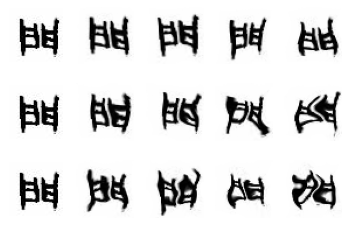

In [10]:
block_num=3
block=15
num=30
name='./img/oracle_200_5_shot/FFD_train_%s_block%s_%s_5_shot/备/备_30.png'%(str(block),str(block_num),str(num))
source=cv2.imread(name,cv2.IMREAD_GRAYSCALE)
float=generate_float(source,row_block_num=block_num,block=block)
#retval = cv2.resize(float[3:47,3:47].copy(),(50,50))

block_num=3
block=0
float=generate_float(source,row_block_num=block_num,block=block)
plt.subplot(3,5, 1), plt.axis("off")
plt.imshow(float,cmap='gray')

block_num=3
block=5
float=generate_float(source,row_block_num=block_num,block=block)
plt.subplot(3,5, 2), plt.axis("off")
plt.imshow(float,cmap='gray')

block_num=3
block=7
float=generate_float(source,row_block_num=block_num,block=block)
plt.subplot(3,5, 3), plt.axis("off")
plt.imshow(float,cmap='gray')

block_num=3
block=9
float=generate_float(source,row_block_num=block_num,block=block)
plt.subplot(3,5, 4), plt.axis("off")
plt.imshow(float,cmap='gray')

block_num=3
block=11
float=generate_float(source,row_block_num=block_num,block=block)
plt.subplot(3,5, 5), plt.axis("off")
plt.imshow(float,cmap='gray')

block_num=5
block=0
float=generate_float(source,row_block_num=block_num,block=block)
plt.subplot(3,5, 6), plt.axis("off")
plt.imshow(float,cmap='gray')

block_num=5
block=5
float=generate_float(source,row_block_num=block_num,block=block)
plt.subplot(3,5, 7), plt.axis("off")
plt.imshow(float,cmap='gray')

block_num=5
block=7
float=generate_float(source,row_block_num=block_num,block=block)
plt.subplot(3,5, 8), plt.axis("off")
plt.imshow(float,cmap='gray')

block_num=5
block=9
float=generate_float(source,row_block_num=block_num,block=block)
plt.subplot(3,5, 9), plt.axis("off")
plt.imshow(float,cmap='gray')

block_num=5
block=11
float=generate_float(source,row_block_num=block_num,block=block)
plt.subplot(3,5, 10), plt.axis("off")
plt.imshow(float,cmap='gray')


block_num=7
block=0
float=generate_float(source,row_block_num=block_num,block=block)
plt.subplot(3,5, 11), plt.axis("off")
plt.imshow(float,cmap='gray')

block_num=7
block=5
float=generate_float(source,row_block_num=block_num,block=block)
plt.subplot(3,5, 12), plt.axis("off")
plt.imshow(float,cmap='gray')

block_num=7
block=7
float=generate_float(source,row_block_num=block_num,block=block)
plt.subplot(3,5, 13), plt.axis("off")
plt.imshow(float,cmap='gray')

block_num=7
block=9
float=generate_float(source,row_block_num=block_num,block=block)
plt.subplot(3,5, 14), plt.axis("off")
plt.imshow(float,cmap='gray')

block_num=7
block=11
float=generate_float(source,row_block_num=block_num,block=block)
plt.subplot(3,5, 15), plt.axis("off")
plt.imshow(float,cmap='gray')
plt.xlabel('Maximum Offset')
plt.ylabel('Num of Blocks')

plt.savefig('output3.pdf')
plt.show()
#plt.subplot(2, 2, 3), plt.axis("off")
#plt.imshow(retval,cmap='gray'),plt.title('retval')